In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Load Model

In [117]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "cntree"
corr = 0.25
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
#model_name = "transformer_end_query_embd512_layer4_head4_lr1e-05_drop0_batch256"
#model_name = "transformer_end_query_embd800_layer3_head4_lr0.0001_drop0_batch256"
#model_name = "transformer_end_query_embd512_layer4_head4_lr1e-05_drop0_batch256"
#model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_batch256"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
print(ckpt_name)
path_to_pkl = os.path.join(model_path, ckpt_name)

eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

epoch=31-val_loss=0.000672.ckpt


In [118]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [119]:
from src.models.transformer_end_query import Transformer
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_758660/79273858.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [120]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [121]:
i_eval = 3
traj = eval_trajs[i_eval]

In [122]:
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': state_dim,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}

In [123]:
env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)


# Run Model

In [124]:
layers = []
positions = []
state_features = []
state_features = list(env.node_map.keys())

for state_feature in state_features:
    layers.append(env.node_map[state_feature].layer)
    positions.append(env.node_map[state_feature].pos)

In [125]:
def run_model(traj, model, state_features, seq_length):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

In [126]:
true_dist_matrix = []

for state_feature in state_features:
    _, dist_from_state = env._make_opt_action_dict(state_feature)
    sorted_dist_from_state = []
    for state_feature in state_features:
        sorted_dist_from_state.append(dist_from_state[state_feature])
    true_dist_matrix.append(sorted_dist_from_state)

true_dist_matrix = np.array(true_dist_matrix)


In [127]:
K_input = 0.8 ** true_dist_matrix

In [128]:
def get_kernel_alignment(K_A, K_B):
    numerator = np.trace(K_A @ K_B)
    denominator = np.sqrt(np.trace(K_A @ K_A) * np.trace(K_B @ K_B))
    alignment = numerator/denominator
    return alignment

def get_kernel_alignment(K_A, K_B):
    # Center the kernel matrices
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

In [129]:
dist_func = lambda data: squareform(pdist(data, metric='correlation'))
#dist_func = lambda data: squareform(pdist(data))

def get_dist_metric(hidden_states, true_dist_matrix, random_ctrl=False):
    kas = []
    dist_matrices = []
    for layer in range(len(hidden_states)):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        if random_ctrl:
            np.random.shuffle(data)

        representation_dist_matrix = dist_func(data)
        clip_val = np.percentile(representation_dist_matrix, 99)
        representation_dist_matrix = np.clip(representation_dist_matrix, None, clip_val)
        representation_dist_matrix = representation_dist_matrix / representation_dist_matrix.max()

        data -= data.mean(0)[None,:]
        K_latents = data @ data.T
        kernel_alignment = get_kernel_alignment(K_input, K_latents)
        kas.append(kernel_alignment)
        dist_matrices.append(representation_dist_matrix)
    return kas, dist_matrices

In [130]:
def make_pca_plots(hidden_states):
    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, n_layers, figsize=(8, 8 * n_layers))
    for layer in range(n_layers):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token

        # Perform PCA
        pca = PCA(n_components=100)
        data_pca = pca.fit_transform(data)
        data_pca = data_pca / np.abs(data_pca).max(axis=0)
        # Plot the PCA results
        axs[layer].scatter(
            data_pca[:, 0], data_pca[:, 1],
            c=layers, cmap='plasma', s=10,
            alpha=0.7)
        axs[layer].set_aspect('equal', 'box')
        axs[layer].set_title(f'Layer {layer}')
        axs[layer].set_box_aspect(1)
        # Remove ticks and labels
        axs[layer].set_xticks([])
        axs[layer].set_yticks([])
        # Add box outline on all sides
        for spine in axs[layer].spines.values():
            spine.set_visible(True)
    plt.tight_layout()
    plt.show()


Sequence Length: 1


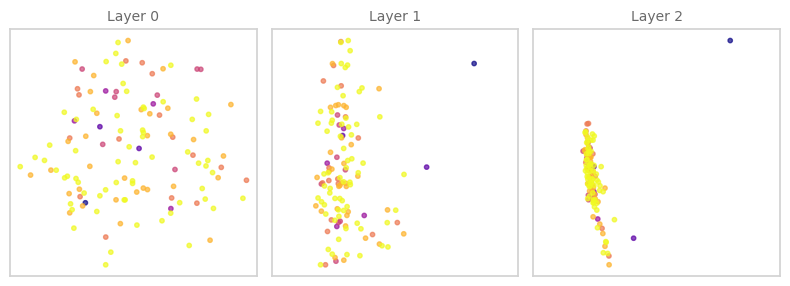

Sequence Length: 25


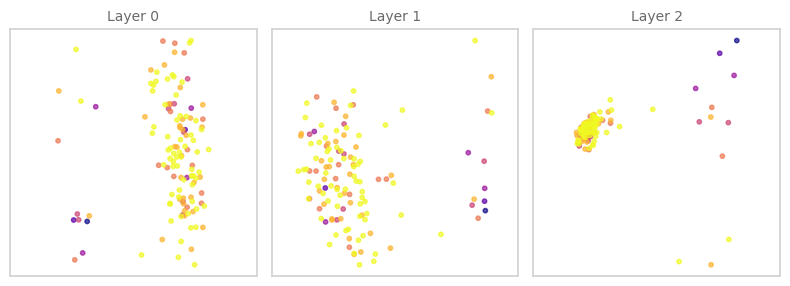

Sequence Length: 50


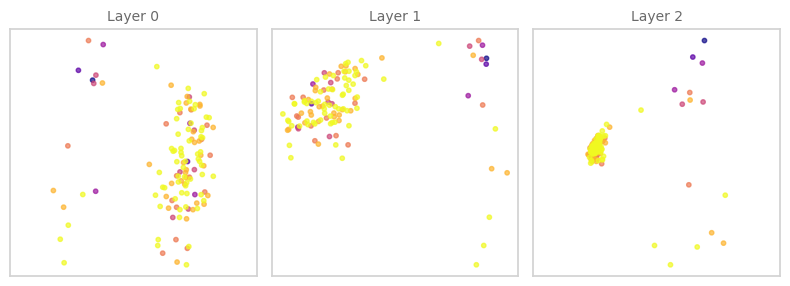

Sequence Length: 75


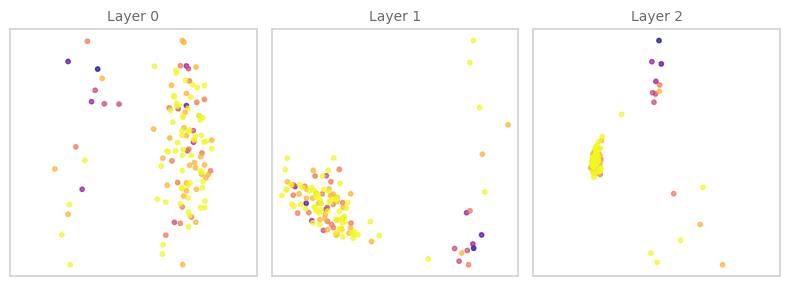

Sequence Length: 100


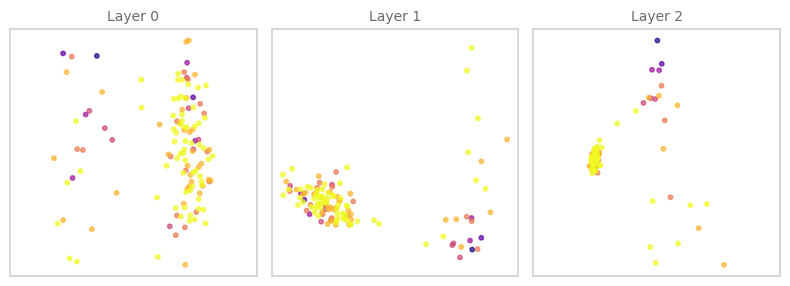

Sequence Length: 250


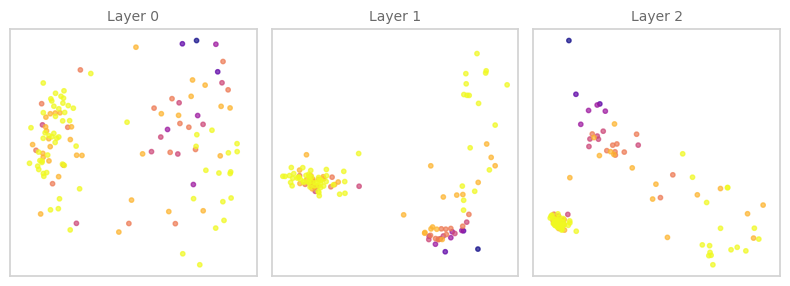

Sequence Length: 500


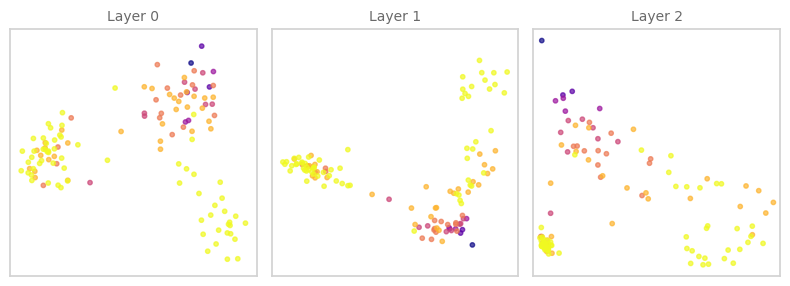

Sequence Length: 750


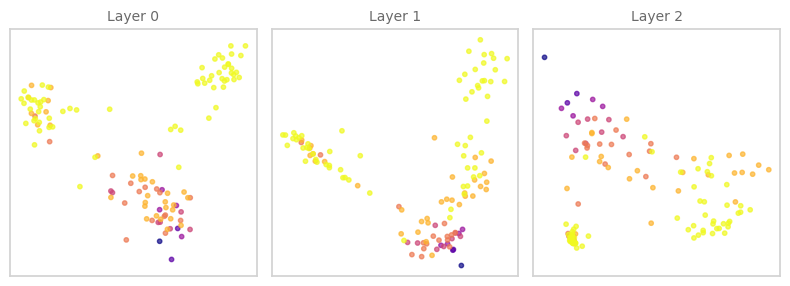

Sequence Length: 1000


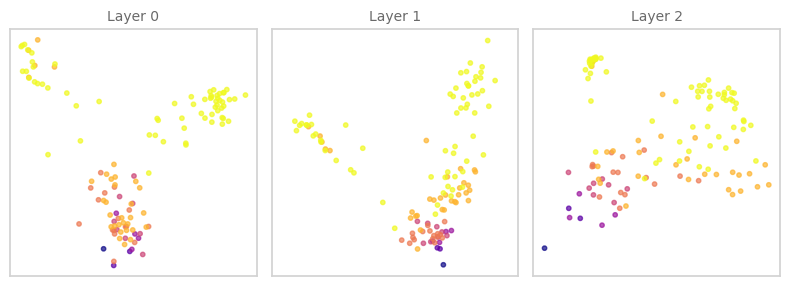

In [131]:
dist_results = {
    'seq_length': [],
    'layer': [],
    'diff': [], 
    'random_diff': []
}
seq_lengths = [1, 25, 50, 75, 100, 250, 500, 750, 1000]
for seq_length in seq_lengths:
    print(f'Sequence Length: {seq_length}')
    hidden_states = run_model(traj, model, state_features, seq_length)
    make_pca_plots(hidden_states)
    diffs, dist_matrices = get_dist_metric(hidden_states, true_dist_matrix)
    random_diffs, _ = get_dist_metric(hidden_states, true_dist_matrix, random_ctrl=True)
    dist_results['seq_length'].extend([seq_length] * model.n_layer)
    dist_results['layer'].extend(range(model.n_layer))
    dist_results['diff'].extend(diffs)
    dist_results['random_diff'].extend(random_diffs)
    # Clear GPU memory
    del hidden_states
    torch.cuda.empty_cache()

dist_results = pd.DataFrame(dist_results)


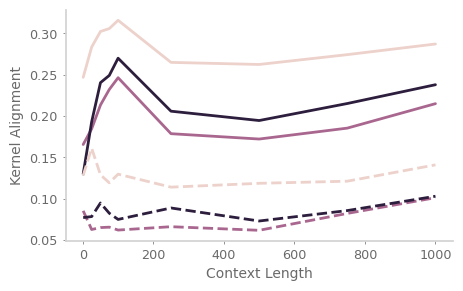

In [132]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=dist_results, x='seq_length', y='diff', hue='layer',
    linewidth=2,
    ax=ax, legend=False)
sns.lineplot(
    data=dist_results, x='seq_length', y='random_diff', hue='layer',
    linewidth=2, linestyle='--',
    ax=ax, legend=False)
ax.set_xlabel('Context Length')
ax.set_ylabel('Kernel Alignment')
first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
if first_reward.size > 0:
    ax.axvline(x=first_reward[0], color='black', linestyle='--')
plt.show()